# Vad är målet och hur kan dom KPI:erna jag valt visa hur bra målet har uppnåtts?
Sverige påbörjade sin covid vaccination år 2020, med målet att se till att alla vuxna ska ha blivit erbjuden en dos. Hitills har 87.1% av dom som >=12 år fått minst en dos. Men i 2022, 2 år senare, är covid vaccination fortfarande en pågående process. 

[COVID-19 vaccination in Sweden](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_Sweden)


**Bra statistik att hålla koll på:**
* Andel infekterade jämfört med andel vaccinerade med minst 1 dos inom för varje län, och hela sverige.
* Antal vaccinerade per vecka
* 

In [116]:

import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import plotly_express as px

infection_statistics_xls = pd.ExcelFile('Rådata/Folkhalsomyndigheten_Covid19.xlsx')
vaccine_statistics_xls = pd.ExcelFile('Rådata/Folkhalsomyndigheten_Covid19_Vaccine.xlsx')

#veckodata_riket = pd.read_excel(infection_statistics_xls, 'Veckodata Riket')
#veckodata_riket['Vecka'] = [f'{year}v{week}' for year, week in zip(veckodata_riket.loc[:,'år'], veckodata_riket.loc[:,'veckonummer'])]
#veckodata_riket.drop(['år', 'veckonummer'], axis=1, inplace=True)

C:\Users\ricka\AppData\Local\Temp\ipykernel_3912\1667066297.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(df['Vecka'], rotation=90) # Används bara för att rotera namnen. Det blir lite konstigt att avläsa x-värderna men utan detta så går det inte att läsa av alls.


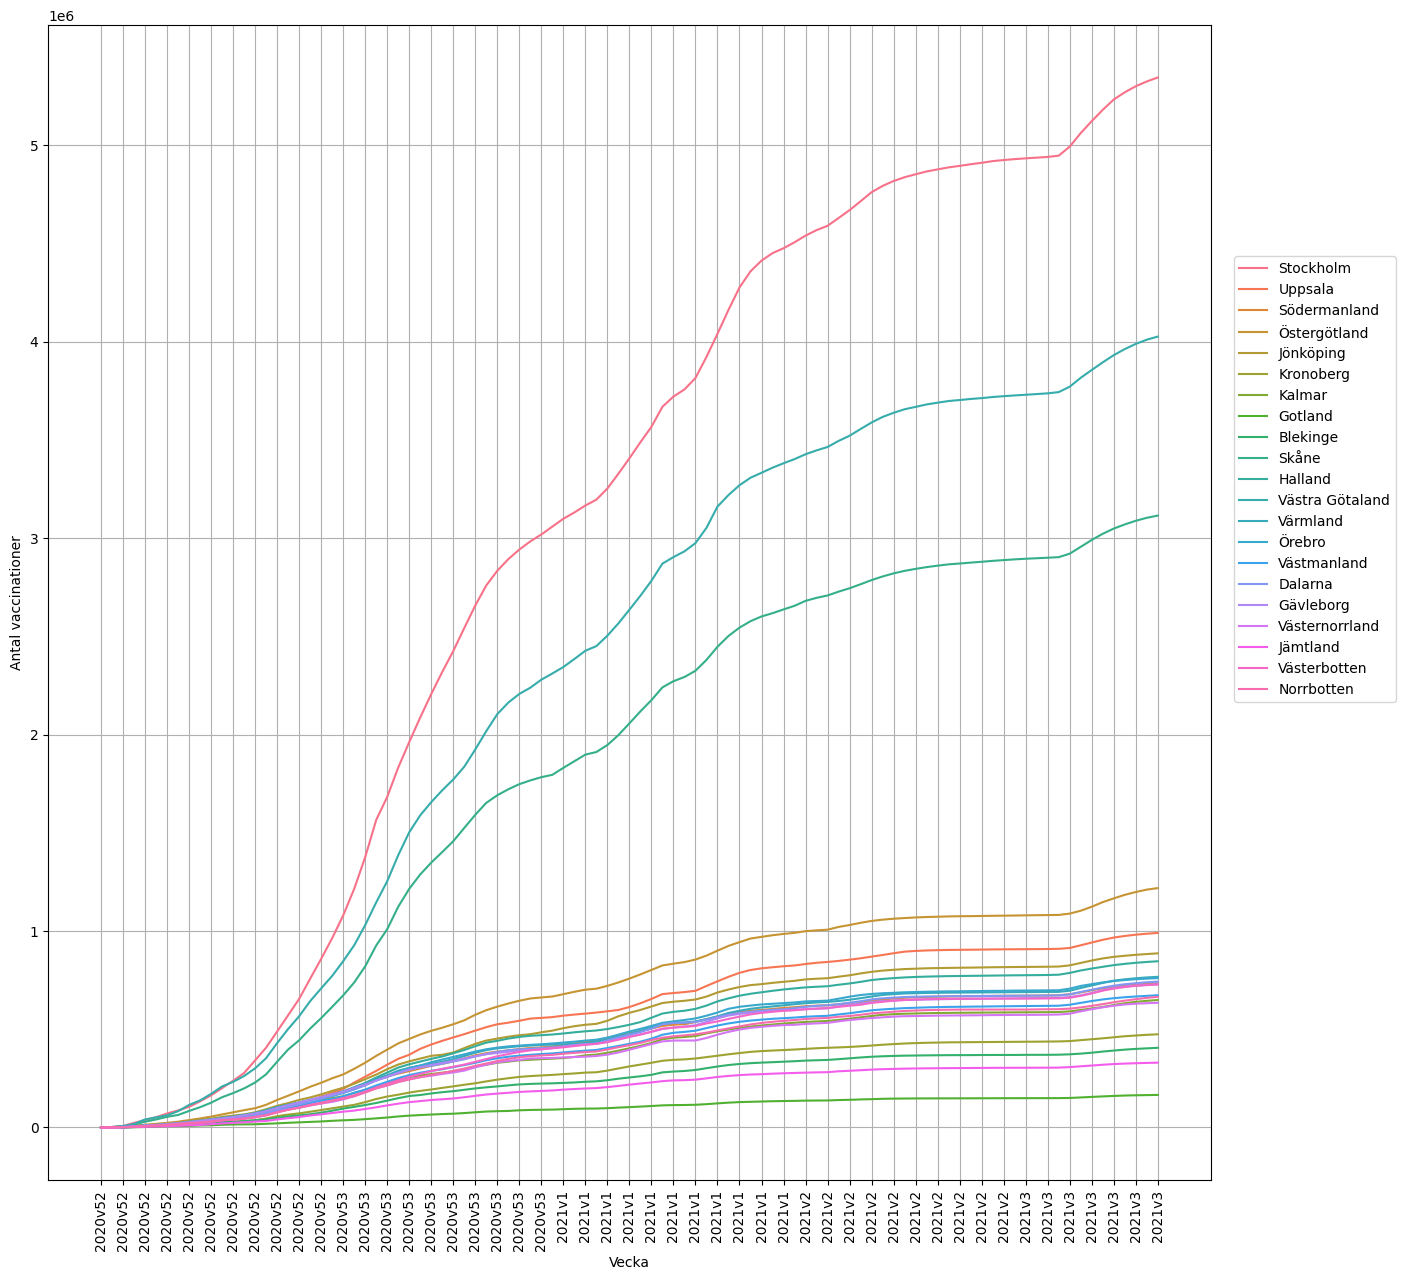

In [117]:
plt.figure(figsize=(15,15))
df = pd.read_excel(vaccine_statistics_xls, 'Vaccinationer tidsserie') # Denna excel flik har mer än nog med information för detta.
df['Vecka'] = [f'{year}v{week}' for year, week in zip(df.loc[:,'År'], df.loc[:,'Vecka'])] # Fixar en kolumn som håller koll på både år och vecka.
df = df.loc[df['Region'] != '| Sverige |'].reset_index() # Ta bort '| Sverige |' för att hålla grafen mer balanserad.

fig = sns.lineplot(data=df, x='Vecka', y='Antal vaccinationer', hue='Region') # 'hue' ser till att varje region får sitt egna linje.
fig.set_xticklabels(df['Vecka'], rotation=90) # Används bara för att rotera namnen. Det blir lite konstigt att avläsa x-värderna men utan detta så går det inte att läsa av alls.
fig.grid() # För att göra det lättare att läsa x,y par.
plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0); # Add a legend to show labels of each bar.

# https://stackoverflow.com/questions/42103348/how-to-improve-spacing-of-labels-on-seaborn-axis 
# Med .set_xticks blev det fel på grafen, med .set_xticklabels blir det dålig mellanrum på namnen. Jag får testa denna metod, med lite variation.
xticks = fig.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%2:
        xticks[i].set_visible(False)

# Notera!
Denna graf visar bara kumulativ antal vaccinationer per vecka!

Detta är ändå intressant att hålla koll på, men för att ta reda vaccinations processens fart så behöver vi istället kolla på skillnaden mellan dom som blev vaccinerade jämfört med dom som redan var det förut.

## KPI 1:
### Vaccinations farten

In [118]:
#plt.figure(figsize=(15,15))

#https://www.geeksforgeeks.org/python-initialize-a-dictionary-with-only-keys-from-a-list/
#sums = {}
#for region in df['Region']: # Skapa en lista för att hålla koll på antal vaccinationer. 21st regioner.
#    sums[region] = 0

vacc_list = list(df['Antal vaccinationer'])
df_diff = df.drop('Antal vaccinationer', axis=1).reset_index()

for index, row in df.iterrows():
    if (index-21) < 0: # Det finns 21st regioner, alltså måste vi först gå igenom dom första 21 elementen innan man gör beräkningar.
       continue
    df.at[index, 'Antal vaccinationer'] -= [(index-21)] # Subtrahera med värdet från förra veckan för att få fram differensen.
    #df.at[index, 'Antal vaccinationer'] = row['Antal vaccinationer'] - sums[row['Region']]  # Loopa igenom alla värden och spara skillnaderna mellan gamla och nya antal.
    #sums[row['Region']] += row['Antal vaccinationer'] # Uppdatera summan vi har än så länge.

#fig = sns.lineplot(data=df_diff, x='Vecka', y='Antal vaccinationer', hue='Region') # 'hue' ser till att varje region får sitt egna linje.
#fig.set_xticklabels(df_diff['Vecka'], rotation=90) # Används bara för att rotera namnen. Det blir lite konstigt att avläsa x-värderna men utan detta så går det inte att läsa av alls.
#fig.grid() # För att göra det lättare att läsa x,y par.
#plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0);

df.head(-5)



,index,Vecka,År,Region,Antal vaccinationer
0,1,2020v52,2020,Stockholm,289
1,2,2020v52,2020,Uppsala,9
2,3,2020v52,2020,Södermanland,116
3,4,2020v52,2020,Östergötland,214
4,5,2020v52,2020,Jönköping,44
...,...,...,...,...,...
2027,2124,2022v43,2022,Västra Götaland,4024071
2028,2125,2022v43,2022,Värmland,764785
2029,2126,2022v43,2022,Örebro,758282
2030,2127,2022v43,2022,Västmanland,671145


## KPI 2: 
### Antal fall per vecka emot antal vaccinerade varje vecka
Den här KPI:n har syftet att mäta det påverkan som andel vaccinerade har haft på andel infekterade. Den kommer baseras på det jag kommit fram till med den första KPI:n.
Detta må låta uppenbart - men detta tycker jag berättigas pg.a att:
* Fastän man är vaccinerad, så finns det ändå en risk att man får covid; Alltså betyder det att antalet vaccinerade är inte lika med antalet som inte fick covid.
* Man kan ha fått covid innan man vaccinerade sig.

I samband med denna KPI kommer också andra intressanta frågor att utforskas - t.ex. vilka åldrar ser ut att vara riskgrupper? (Detta kommer också verifieras med en källa)

## KPI 3: